In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

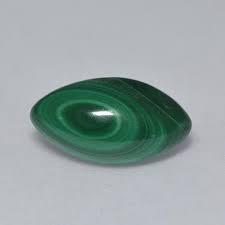

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Create train and test dir paths
train_data_dir = "../raw_data/train/"
test_data_dir = "../raw_data/test/"

img = load_img(f"{train_data_dir}Malachite/malachite_15.jpg")
X = img_to_array(img)

img

In [ ]:
X.shape

(225, 225, 3)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory

# Creating a base model

In [ ]:
base_model = Sequential()

base_model.add(layers.Input((225, 225, 3)))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(87, activation="softmax"))

base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 151875)            0         
                                                                 
 dense_4 (Dense)             (None, 87)                13213212  
                                                                 
Total params: 13,213,212
Trainable params: 13,213,212
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
base_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

batch_size = 64

# Create a training dataset
train_ds = image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(225, 225),
    batch_size=batch_size
)

# We define a second one for the test data

val_ds = image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(225, 225),
    batch_size=batch_size
)

Found 2856 files belonging to 87 classes.
Found 363 files belonging to 87 classes.


In [ ]:
# Fitting the base model

base_history = base_model.fit(
        train_ds,
        epochs=5,
        validation_data=val_ds,
        )

Epoch 1/5
45/45 [==============================] - 17s 242ms/step - loss: 129898.8906 - accuracy: 0.0200 - val_loss: 237268.0156 - val_accuracy: 0.0303
Epoch 2/5
45/45 [==============================] - 8s 169ms/step - loss: 145079.3125 - accuracy: 0.0494 - val_loss: 60663.8008 - val_accuracy: 0.0799
Epoch 3/5
45/45 [==============================] - 8s 173ms/step - loss: 33367.2773 - accuracy: 0.1236 - val_loss: 16981.2461 - val_accuracy: 0.1405
Epoch 4/5
45/45 [==============================] - 10s 205ms/step - loss: 10312.8848 - accuracy: 0.2073 - val_loss: 9693.4434 - val_accuracy: 0.1763
Epoch 5/5
45/45 [==============================] - 9s 196ms/step - loss: 9110.4873 - accuracy: 0.2150 - val_loss: 14892.1572 - val_accuracy: 0.1515


# Creating a better model

In [ ]:
model_v2_1 = Sequential()

model_v2_1.add(layers.Input((225, 225, 3)))
model_v2_1.add(layers.Rescaling(1./225))

model_v2_1.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model_v2_1.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )


model_v2_1.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model_v2_1.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )


model_v2_1.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"))
model_v2_1.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )

model_v2_1.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model_v2_1.add(layers.Dense(64, activation="relu"))

model_v2_1.add(layers.Dropout(0.5))

model_v2_1.add(layers.Dense(87, activation="softmax"))

model_v2_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 225, 225, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 57, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 64)       

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)

MODEL = "../models/model_v2_1.keras"

modelCheckpoint = callbacks.ModelCheckpoint(MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

In [65]:
model_v2_1.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

history = model_v2_1.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        batch_size=batch_size,
        callbacks=[modelCheckpoint,LRreducer, EarlyStopper]
        )

Epoch 1/3
45/45 [==============================] - 259s 5s/step - loss: 3.0341 - accuracy: 0.1408 - val_loss: 2.5006 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 2/3
45/45 [==============================] - 70s 2s/step - loss: 3.0441 - accuracy: 0.1474 - val_loss: 2.5071 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/3
45/45 [==============================] - 55s 1s/step - loss: 3.0103 - accuracy: 0.1509 - val_loss: 2.4703 - val_accuracy: 0.3388 - lr: 0.0010


In [75]:
from tensorflow.keras.preprocessing import image

img = load_img(f"{test_data_dir}Coral/coral_18.jpg", target_size=(225, 225))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects batches of input
img_array = np.expand_dims(img_array, axis=0)

prediction = model_v2_1.predict(img_array)

class_names = train_ds.class_names
predicted_class = np.argmax(prediction[0])
predicted_label = class_names[predicted_class]

print(f"Predicted class: {predicted_label}")

1/1 [==============================] - 0s 60ms/step
Predicted class: Sunstone


# Exporting the improved model

In [ ]:
model_v2_1.save('../models/model_v2_1.keras')

# Plotting learning plots

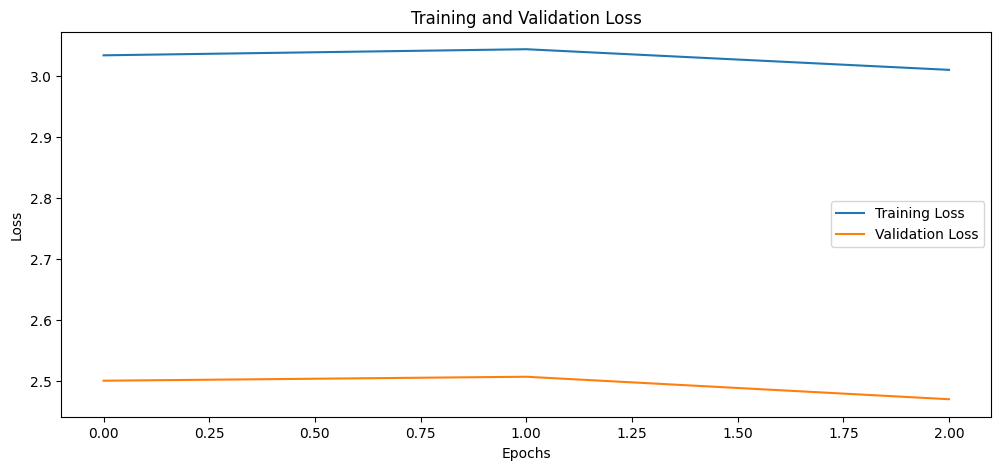

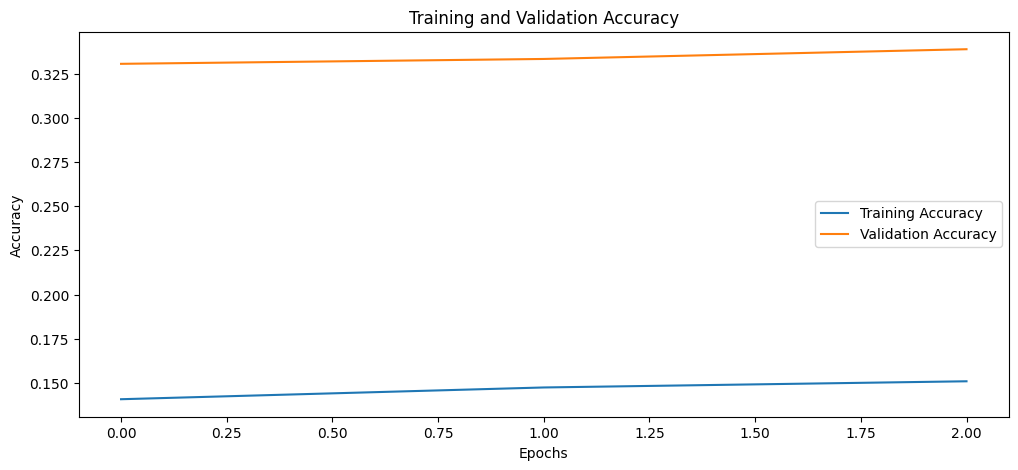

In [76]:
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
best_val_acc